# Building a Neural Network and understanding the Forward Pass

## Step 1: Set Up the Environment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility of random initial weights
torch.manual_seed(42)

## Step 2: Defining the Neural Network Structure




In [ ]:
def plot_decision_boundary(X_data, model_weights, model_bias, ax, label, linestyle='--', color='red', show_points=True):
    """
    Plots the decision boundary for a linear layer (w1*x1 + w2*x2 + b = 0).
    The boundary is where the input to the sigmoid function is 0.
    """
    w1, w2 = model_weights[0, 0].item(), model_weights[0, 1].item()
    b = model_bias[0].item()

    # Create a range of x1 values
    x1_vals = np.linspace(X_data[:, 0].min() - 1, X_data[:, 0].max() + 1, 100)
    # Calculate corresponding x2 values for the line w1*x1 + w2*x2 + b = 0
    # x2 = (-w1*x1 - b) / w2
    if w2 != 0: # Avoid division by zero if w2 is zero
        x2_vals = (-w1 * x1_vals - b) / w2
        ax.plot(x1_vals, x2_vals, linestyle, color=color, label=f'{label} (z=0 line)')
    elif w1 != 0: # If w2 is zero, the line is vertical: x1 = -b / w1
        x1_const = -b / w1
        ax.axvline(x1_const, linestyle=linestyle, color=color, label=f'{label} (z=0 line, vertical)')
    # If both w1 and w2 are zero, no simple line to plot (degenerate case)

    if show_points:
        ax.scatter(X_data[:, 0].numpy(), X_data[:, 1].numpy(), c='gray', alpha=0.5, label='Data Points (for context)')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.grid(True)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # A single linear layer: 2 input features, 1 output feature
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        # Pass input through the linear layer
        x = self.fc1(x)
        # Apply sigmoid activation to constrain output between 0 and 1
        x = torch.sigmoid(x)
        return x

## Step 3: Creating a Dataset

Input data X:
tensor([[0.5000, 1.0000],
        [1.5000, 1.5000],
        [3.0000, 2.5000]])

Target data y:
tensor([[0.],
        [1.],
        [1.]])


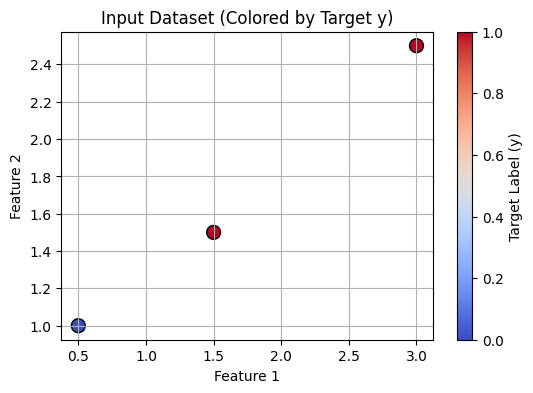

In [ ]:
# Synthetic dataset: X contains input features, y contains target labels
X = torch.tensor([[0.5, 1.0],
                  [1.5, 1.5],
                  [3.0, 2.5]], dtype=torch.float32)

# Target labels (0 or 1 for binary classification type problems)
y = torch.tensor([[0.0],
                  [1.0],
                  [1.0]], dtype=torch.float32)

print("Input data X:")
print(X)
print("\nTarget data y:")
print(y)

# Visualize the input dataset
plt.figure(figsize=(6, 4))
scatter_y = y.squeeze().numpy() # Use y for color if available and meaningful
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=scatter_y, cmap='coolwarm', s=100, edgecolor='k')
plt.title('Input Dataset (Colored by Target y)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Target Label (y)')
plt.grid(True)
plt.show()

## Step 4: Instantiating the Model and Inspecting Initial Weights



Model architecture:
SimpleNN(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)

Initial weights of fc1:
tensor([[0.5406, 0.5869]])

Initial bias of fc1:
tensor([-0.1657])


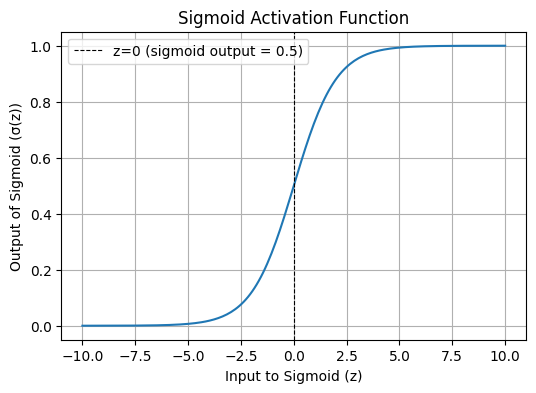

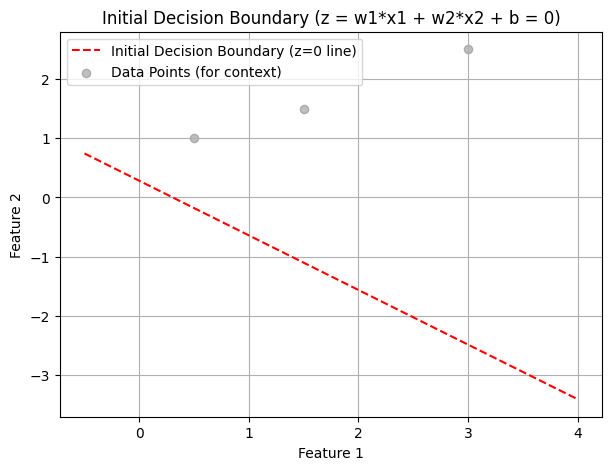

In [ ]:
model = SimpleNN()

print("\nModel architecture:")
print(model)

initial_weights = model.fc1.weight.data.clone() # Store a copy for plotting
initial_bias = model.fc1.bias.data.clone()     # Store a copy for plotting

print("\nInitial weights of fc1:")
print(initial_weights)
print("\nInitial bias of fc1:")
print(initial_bias)

# Visualize the Sigmoid Activation Function
plt.figure(figsize=(6, 4))
z_vals = torch.linspace(-10, 10, 200)
sigmoid_vals = torch.sigmoid(z_vals)
plt.plot(z_vals.numpy(), sigmoid_vals.numpy())
plt.title('Sigmoid Activation Function')
plt.xlabel('Input to Sigmoid (z)')
plt.ylabel('Output of Sigmoid (Ïƒ(z))')
plt.grid(True)
plt.axvline(0, color='black', linestyle='--', lw=0.8, label='z=0 (sigmoid output = 0.5)')
plt.legend()
plt.show()

# Visualize the initial decision boundary (where input to sigmoid is 0)
fig_boundary_init, ax_boundary_init = plt.subplots(figsize=(7, 5))
plot_decision_boundary(X, initial_weights, initial_bias, ax_boundary_init, 'Initial Decision Boundary')
ax_boundary_init.set_title('Initial Decision Boundary (z = w1*x1 + w2*x2 + b = 0)')
plt.show()

## Step 5: Forward Pass (Raw Output)

In [ ]:
def visualize_forward_pass_predictions(model_instance, X_data):
    model_instance.eval()
    with torch.no_grad():
        raw_outputs = model_instance(X_data) # These are already sigmoid outputs

    print("\n--- Forward Pass Visualization (Sigmoid Outputs) ---")
    for i in range(X_data.shape[0]):
        input_sample = X_data[i]
        output_prediction = raw_outputs[i]
        # Also show the input to the sigmoid
        with torch.no_grad(): # Recalculate pre-sigmoid for inspection
            pre_sigmoid_output = model_instance.fc1(input_sample.unsqueeze(0))

        print(f"Input: {input_sample.numpy()} -> Pre-Sigmoid: {pre_sigmoid_output.item():.4f} -> Sigmoid Output: {output_prediction.item():.4f}")
    return raw_outputs

model_outputs_after_sigmoid = visualize_forward_pass_predictions(model, X)


--- Forward Pass Visualization (Sigmoid Outputs) ---
Input: [0.5 1. ] -> Pre-Sigmoid: 0.6916 -> Sigmoid Output: 0.6663
Input: [1.5 1.5] -> Pre-Sigmoid: 1.5256 -> Sigmoid Output: 0.8214
Input: [3.  2.5] -> Pre-Sigmoid: 2.9234 -> Sigmoid Output: 0.9490


## Step 6: Plotting Input vs. Output

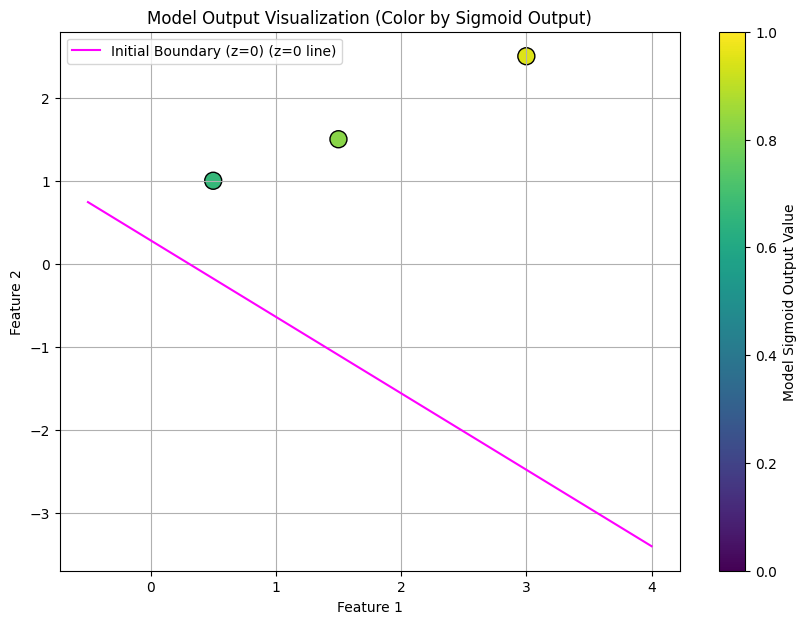

In [ ]:
# model_outputs_after_sigmoid are the outputs from the sigmoid function.
plot_outputs_np = model_outputs_after_sigmoid.numpy()

plt.figure(figsize=(10, 7)) # Made figure larger for clarity
# Scatter plot of the input features X[:, 0] and X[:, 1]
# The color of each point is determined by the model's sigmoid output value
scatter = plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=plot_outputs_np, cmap='viridis', s=150, edgecolor='k', vmin=0, vmax=1)

plt.title('Model Output Visualization (Color by Sigmoid Output)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Model Sigmoid Output Value')
plt.grid(True)

# Overlay the initial decision boundary (z=0 line) on this plot for context
# We need to pass the current axes to the plotting function
current_ax = plt.gca()
plot_decision_boundary(X, initial_weights, initial_bias, current_ax, 'Initial Boundary (z=0)', linestyle='-', color='magenta', show_points=False)

plt.show()


## Step 7: Plotting Original vs. Model Boundaries

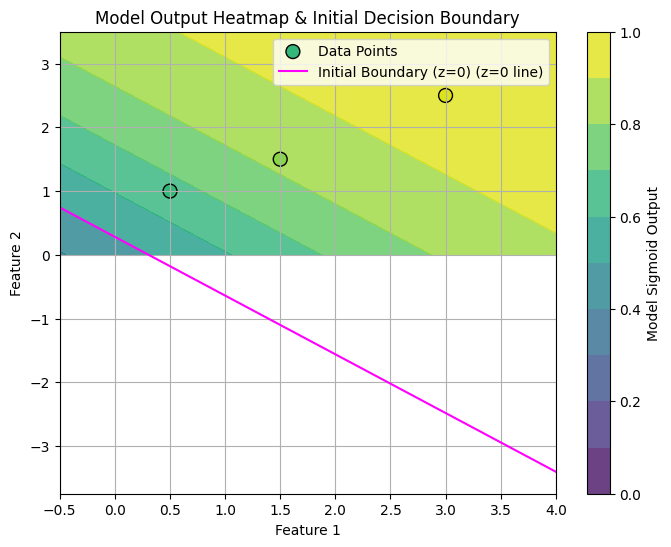

In [ ]:
model.eval()
with torch.no_grad():
    # Create a grid of points
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))

    # Convert grid to PyTorch tensor
    grid_tensor = torch.tensor(np.c_[xx1.ravel(), xx2.ravel()], dtype=torch.float32)

    # Get model predictions for each point on the grid
    grid_predictions = model(grid_tensor).reshape(xx1.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(xx1, xx2, grid_predictions.numpy(), cmap='viridis', alpha=0.8, levels=np.linspace(0,1,11))
plt.colorbar(contour, label='Model Sigmoid Output')
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=plot_outputs_np.squeeze(), cmap='viridis', s=100, edgecolor='k', vmin=0, vmax=1, label='Data Points')
# Overlay the decision boundary (z=0 line)
plot_decision_boundary(X, initial_weights, initial_bias, plt.gca(), 'Initial Boundary (z=0)', linestyle='-', color='magenta', show_points=False)
plt.title('Model Output Heatmap & Initial Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()